<a href="https://colab.research.google.com/github/Harshavardhan200/RL_Assignment/blob/main/Assignement_checkpoint.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import gymnasium as gym
from gymnasium import spaces
import numpy as np
import matplotlib.pyplot as plt
import pickle
import matplotlib.image as mpimg
import random
import imageio

In [ ]:
class EnvWareHouseDet(gym.Env):
  def __init__(self):

    self.grid = 6
    self.observation_space = spaces.Discrete(self.grid*self.grid*4)     # [[Coordinates_x, Coordinates_Y], Pickup status1, Pickupstatus2]
    self.action_space = spaces.Discrete(6)     #UP, DOWN, LEFT, RIGHT, PICK UP, DROP OFF
    self.max_timestamps = 10                    # Maximum activities
    self.state = self.reset()                                                   #reset the game environment
  def reset(self, **kwargs):
    self.prev_pos = [5, 0]                                           #Previous position
    self.carry = [False, False]                                         #Select the carry status
    self.reward = 0                                           #Set the reward as zero
    self.done = False
    self.timestamps = 0                          #Initiate timestamps
    self.obstacles = [(1, 1), (4, 0), (2, 5), (4, 4)]  # Obstacles Coordinates
    self.dropoff = [5, 5]  # Exit
    self.agent = [5, 0]  # Agent Position
    set_of_all_points = set(self.obstacles + [tuple(self.dropoff), tuple(self.agent)])
    self.pickup = []
    self.pickup = [(5, 4)]
    self.rewards = {"Successful": 100,
                    "pickup for first time": 25,
                    "obstacle": -20,
                    "step_penalty": -1}                        # Rewards dictionary
    self.state = np.zeros((self.grid, self.grid))              #State Space
    self.state = np.full((self.grid, self.grid), self.rewards["step_penalty"])            # set the penalties for all state
    for x, y in self.obstacles:
      self.state[(x, y)] = self.rewards["obstacle"]                                   #Set the obstacle points with penalty
    self.state[tuple(self.agent)] = 1                         #Set the agent_position
    self.state[tuple(self.dropoff)] = self.rewards["Successful"]                         # Set the exit with reward points
    for pickup in self.pickup:
      self.state[tuple(pickup)] = self.rewards["pickup for first time"]                           #Set the pickup points for first time as 25
    # print(self.state)
    observation_space = (np.array(self.state.flatten()), self.carry)
    return observation_space

  def step(self, action):
    self.prev_pos = self.agent.copy()

    terminated = self.timestamps >= self.max_timestamps
    if terminated or self.done:
        self.reset()
    # Move agent based on action
    if action == 0:  # down
        self.agent[0] += 1
    elif action == 1:  # up
        self.agent[0] -= 1
    elif action == 2:  # right
        self.agent[1] += 1
    elif action == 3:  # left
        self.agent[1] -= 1

    # Check whether in limits or hit obstacle
    if not (0 <= self.agent[0] < self.grid and 0 <= self.agent[1] < self.grid) or tuple(self.agent) in self.obstacles:
        self.agent = self.prev_pos
        self.reward += self.rewards["obstacle"]

    #  Auto Pickup Logic
    elif tuple(self.agent) in self.pickup:
        index = self.pickup.index(tuple(self.agent))
        if not self.carry:  # If that box is not yet carried
            self.carry = True
            self.pickup.pop(index)  # Remove from available pickups
            self.reward += self.rewards["pickup for first time"]

    # Auto Dropoff Logic
    elif self.agent == self.dropoff and self.carry:  # If carrying anything
        self.reward += self.rewards["Successful"]
        if not self.carry:  # If no boxes left, exit
            self.done = True
    else:
        self.reward += self.rewards["step_penalty"]

    # Update grid state instead of resetting completely
    self.state = np.full((self.grid, self.grid), -1)  # Reset state but keep history
    for x, y in self.obstacles:
        self.state[x, y] = self.rewards["obstacle"]
    for pickup in self.pickup:
        self.state[pickup] = self.rewards["pickup for first time"]

    # Update agent position properly
    self.state[self.agent[0], self.agent[1]] = 1
    self.timestamps += 1

    observation_space = (self.state.flatten(), self.carry)

    return observation_space, self.reward, False, False, self.done



  def render(self):
    plt.figure(figsize=(6, 6))
    #grid_matrix statespace for visualzation
    grid_matrix = np.full((self.grid, self.grid), self.rewards["step_penalty"])            # set the penalties for all
    for x, y in self.obstacles:
      grid_matrix[(x, y)] = self.rewards["obstacle"]                                   #Set the obstacle points with penalty
    grid_matrix[tuple(self.agent)] = 1                         #Set the agent_position
    grid_matrix[tuple(self.dropoff)] = self.rewards["Successful"]                         # Set the exit with reward points
    for pickup in self.pickup:
        grid_matrix[tuple(pickup)] = self.rewards["pickup for first time"]                       #Set the pickup points for first time as 25
    # print(grid_matrix)
    #mark the agent as pickup when it drop
    plt.imshow(grid_matrix, cmap="coolwarm", origin="upper")

    plt.xticks(np.arange(self.grid), labels=[str(i) for i in range(self.grid)])                                 #Set the X label ticks of grid
    plt.yticks(np.arange(self.grid), labels=[str(i) for i in range(self.grid)])                                 #Set the Y label ticks of grid
    plt.grid(color="black", linewidth=1)

    for pickup in self.pickup:
        plt.scatter(pickup[1], pickup[0], marker="P", color="blue", s=200, label="Pickup" if pickup == self.pickup[0] else "")              #Set the pickup mark of the gift
    plt.scatter(self.dropoff[1], self.dropoff[0], marker="X", color="green", s=200, label="Dropoff")             #set the exit mark of the delivery

    plt.scatter(self.agent[1], self.agent[0], marker="o", color="black", s=200, label="Agent")            #Set the Agent position

    plt.legend(loc="upper left", fontsize=10, frameon=True)                                                       #Set the legend with legend position
    plt.title("Warehouse Environment", fontsize=14)

    plt.show()

Q Learning for Deterministic

In [ ]:
# Optimized Hyperparameters
alpha = 0.7            # Learning rate
gamma = 0.99           # Discount factor
epsilon = 0.8          # Initial exploration rate
epsilon_decay = 0.999995 # # Slower decay for extended exploration
epsilon_min = 0.05     # Minimum exploration rate
num_episodes = 70000   # More episodes for better training
max_steps = 10         # Max steps per episode
env = EnvWareHouseDet()
# Q-table initialization
state_size = env.observation_space.n
action_size = env.action_space.n
q_table = np.zeros((state_size, action_size))

# Track metrics
total_rewards_ = []
epsilon_values = []

#Get the index of state
def state_index(state, env):
    grid_state, carry = state  # Unpack the observation space
    position = np.where(grid_state.reshape(env.grid, env.grid) == 1)  # Get agent position
    pos_index = position[0][0] * env.grid + position[1][0]  # Convert (x, y) to a single index
    carry_bit = 0
    if len(carry) > 0:
        carry_bit += carry[0] * 2
    if len(carry) > 1:
        carry_bit += carry[1]
    return pos_index + carry_bit * (env.grid * env.grid)

# Choose best action
def choose_action(state, env):
  state_id = state_index(state, env)
  if np.random.uniform(0, 1) < epsilon:
    # print("Explore")
    return env.action_space.sample()  # Explore
  else:
    # print("Exploit")
    return np.argmax(q_table[state_id, :])  # Exploit

#Update the q_table
def update_q_table(state, action, reward, next_state, alpha=0.1, gamma=0.9):
  state_id = state_index(state, env)
  next_state_id = state_index(next_state, env)

  best_next_action = np.argmax(q_table[next_state_id, :])
  td_target = reward + gamma * q_table[next_state_id, best_next_action]   # r + γ max_a' Q(s', a')
  q_table[state_id, action] += alpha * (td_target - q_table[state_id, action])  # Q(s, a) update


epsilon_stop_threshold = 0.050  # Stop training when epsilon reaches this value

for episode in range(num_episodes):
    state = env.reset()
    total_reward = 0
    done = False

    for step in range(max_steps):
        action = choose_action(state, env)
        next_state, reward, terminated, truncated, done = env.step(action)

        update_q_table(state, action, reward, next_state)

        state = next_state
        total_reward += reward
        if done or terminated:
            break

    total_rewards_.append(total_reward)

    # Decay epsilon
    # epsilon = max(epsilon_min, epsilon * epsilon_decay)
    epsilon = epsilon_min + (0.8 - epsilon_min) * np.exp(-episode / (num_episodes / 10))

    epsilon_values.append(epsilon)

    # Stop training when epsilon stops decreasing and reaches 0.050
    if epsilon <= epsilon_stop_threshold:
        print(f"Training stopped at Episode {episode+1} as epsilon reached {epsilon:.3f}")
        break

    # Print progress every 100 episodes
    if (episode + 1) % 100 == 0:
        print(f"Episode {episode+1}/{num_episodes} | Total Reward: {total_reward:.2f} | Epsilon: {epsilon:.4f}")
with open("Q_table_deterministic.pkl", "wb") as f:
    pickle.dump(q_table, f)

Episode 100/70000 | Total Reward: -6.00 | Epsilon: 0.7895
Episode 200/70000 | Total Reward: -55.00 | Epsilon: 0.7790
Episode 300/70000 | Total Reward: -245.00 | Epsilon: 0.7686
Episode 400/70000 | Total Reward: -74.00 | Epsilon: 0.7584
Episode 500/70000 | Total Reward: -245.00 | Epsilon: 0.7484
Episode 600/70000 | Total Reward: -112.00 | Epsilon: 0.7385
Episode 700/70000 | Total Reward: -359.00 | Epsilon: 0.7287
Episode 800/70000 | Total Reward: -530.00 | Epsilon: 0.7191
Episode 900/70000 | Total Reward: -625.00 | Epsilon: 0.7096
Episode 1000/70000 | Total Reward: -359.00 | Epsilon: 0.7003
Episode 1100/70000 | Total Reward: -758.00 | Epsilon: 0.6910
Episode 1200/70000 | Total Reward: -54.00 | Epsilon: 0.6819
Episode 1300/70000 | Total Reward: -112.00 | Epsilon: 0.6730
Episode 1400/70000 | Total Reward: 770.00 | Epsilon: 0.6641
Episode 1500/70000 | Total Reward: -397.00 | Epsilon: 0.6554
Episode 1600/70000 | Total Reward: -55.00 | Epsilon: 0.6468
Episode 1700/70000 | Total Reward: -378.

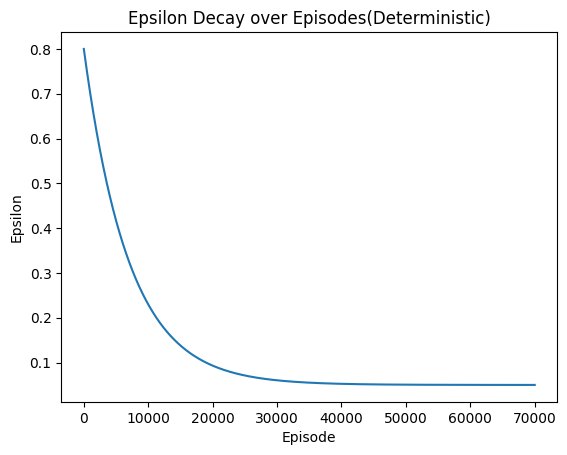

In [ ]:
plt.plot(epsilon_values)
plt.xlabel('Episode')
plt.ylabel('Epsilon')
plt.title('Epsilon Decay over Episodes(Deterministic)')
plt.show()

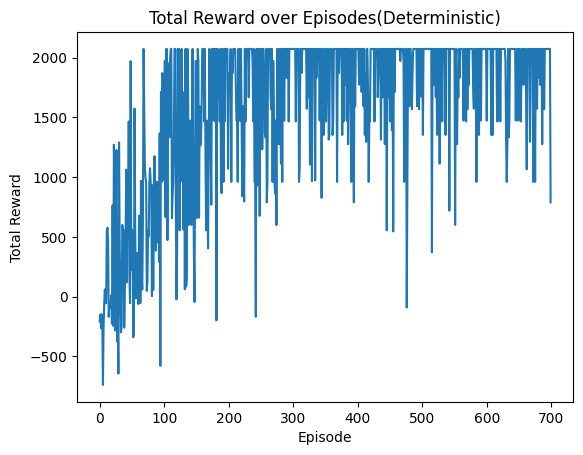

In [ ]:
episodes = list(range(0, len(total_rewards_), 100))
filtered_rewards = [total_rewards_[i] for i in episodes]
plt.plot(filtered_rewards)
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Total Reward over Episodes(Deterministic)')
plt.show()

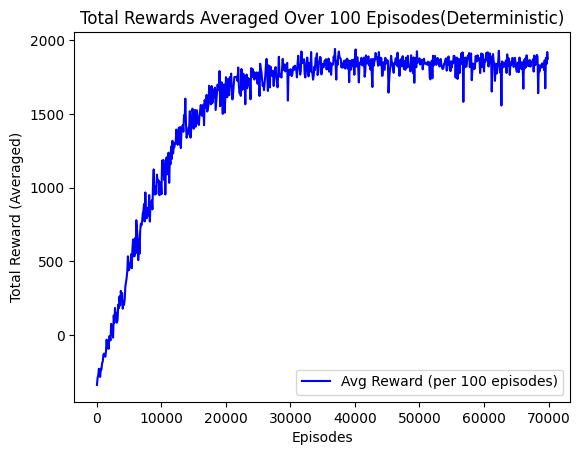

In [ ]:
smoothed_rewards = np.mean(np.array(total_rewards_).reshape(-1, 100), axis=1)

# Plot the averaged rewards
plt.plot(range(0, len(total_rewards_), 100), smoothed_rewards, label="Avg Reward (per 100 episodes)", color='blue')

# Labels and title
plt.xlabel("Episodes")
plt.ylabel("Total Reward (Averaged)")
plt.title("Total Rewards Averaged Over 100 Episodes(Deterministic)")
plt.legend()
plt.show()

Print the trained qtable

In [ ]:
print(q_table)

[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [-2.90000000e+00 -2.90000000e+00 -9.00000000e-01  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00 -1.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00 -4.80000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [-2.90000000e+00 -4.06800000e+00 -1.00000000e+00  0.00000000e+00
  -8.00000000e-01 -1.00000000e+00]
 [-1.00000000e+00 -1.00000000e+00  0.00000000e+00 -4.80000000e+00
  -9.00000000e-01  0.0000

In [ ]:
with open("Q_table_deterministic.pkl", "rb") as f:
    q_table = pickle.load(f)

det = EnvWareHouseDet()
episodes = 10

total_rewards = []

# Run 10 episodes using greedy policy
for episode in range(episodes):
  print(f"Episode {episode+1}/{episodes}")
  state, _ = env.reset()
  state_idx = np.argmax(state[0])  # Convert state to index for lookup
  done = False
  total_reward = 0

  while not done:
      action = np.argmax(q_table[state_idx])  # Always choose the best action (greedy)
      next_state, reward, done, _, _ = env.step(action)
      state_idx = np.argmax(next_state[0])  # Convert to index
      # print(state_idx)
      total_reward += reward

  total_rewards.append(total_reward)

# Plot total rewards per episode
plt.figure(figsize=(8, 5))
plt.plot(range(1, episodes + 1), total_rewards, marker='o', linestyle='-')
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("Total Reward per Episode (Greedy Policy)")
plt.grid()
plt.show()

Episode 1/10


KeyboardInterrupt: 

In [ ]:


# Load the trained Q-table
with open("Q_table_deterministic.pkl", "rb") as f:
    Q_table = pickle.load(f)

# Initialize environment
env = EnvWareHouseDet()

# Store frames for video
frames = []

# Run 1 greedy episode with rendering
state, _ = env.reset()
state_idx = np.argmax(state[0])  # Convert state to index
done = False
step = 0

while not done:
    action = np.argmax(Q_table[state_idx])  # Choose best action (greedy)
    next_state, reward, done, _, _ = env.step(action)

    # Render and save frame
    fig = plt.figure()
    # env.render()
    plt.savefig(f"frame/step_{step}.png")  # Save each step as an image
    plt.close(fig)

    # Convert image to numpy array for video
    frame = imageio.imread(f"frames/step_{step}.png")
    frames.append(frame)

    state_idx = np.argmax(next_state[0])  # Update state index
    step += 1

# Save the video
imageio.mimsave("warehouse_run.mp4", frames, fps=2)  # Save as MP4 video

print("Rendering complete. Screenshots saved in 'frames/' and video saved as 'warehouse_run.mp4'.")


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
print(np.max(Q_table))
print(max(total_rewards_), min(total_rewards_))

433.25070709016046
2073 -986


Hyperparameter tuning

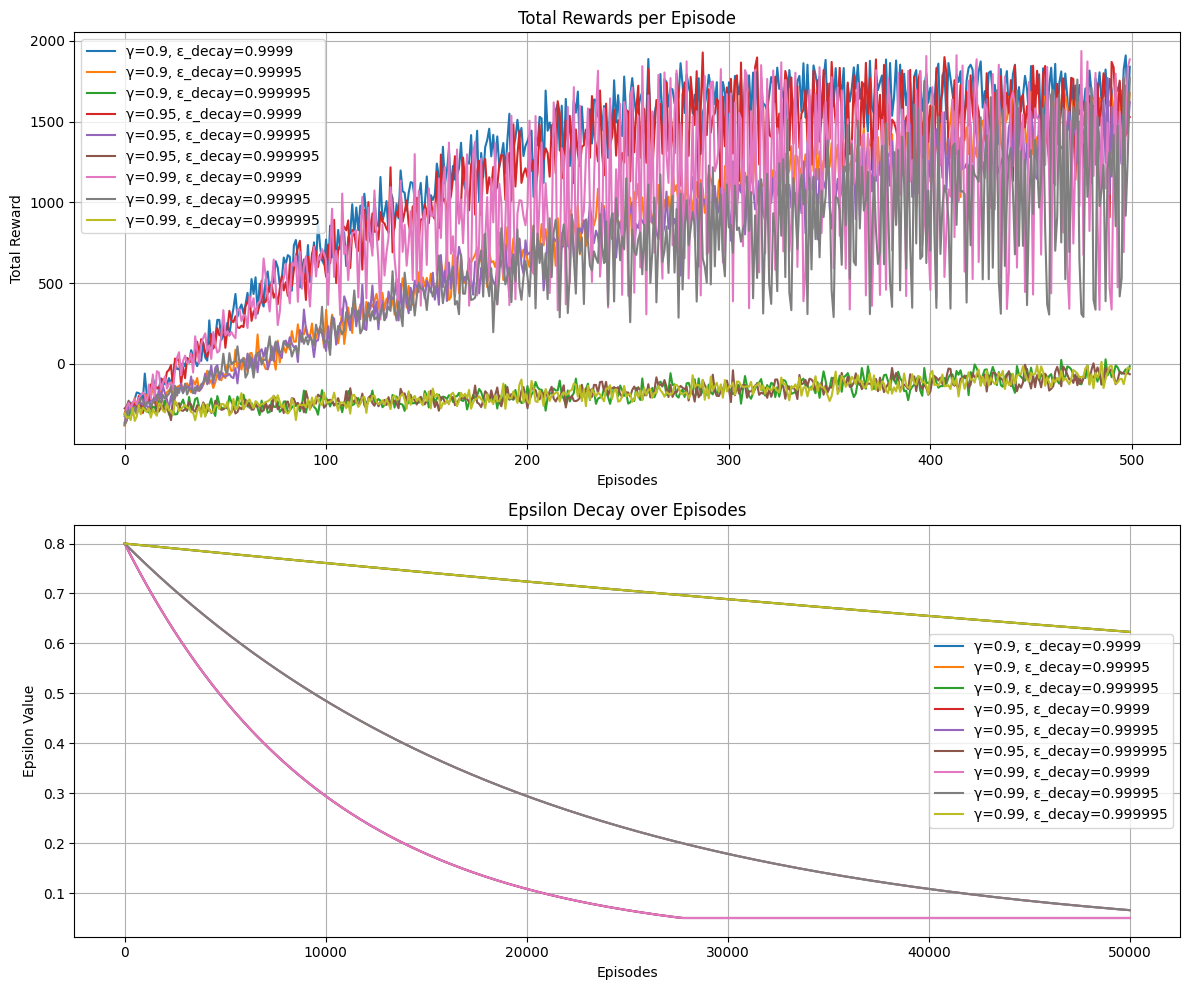

In [ ]:


# Define hyperparameter values to test
gamma_values = [0.9, 0.95, 0.99]  # Discount factor
epsilon_decay_values = [0.9999, 0.99995, 0.999995]  # Exploration decay rate

def train_q_learning(env, gamma, epsilon_decay, num_episodes=50000, alpha=0.7, epsilon=0.8, epsilon_min=0.05, max_steps=10):
    state_size = env.observation_space.n
    action_size = env.action_space.n
    q_table = np.zeros((state_size, action_size))
    total_rewards = []
    epsilon_values = []

    def state_index(state, env):
        grid_state, carry = state  # Unpack observation
        position = np.where(grid_state.reshape(env.grid, env.grid) == 1)
        pos_index = position[0][0] * env.grid + position[1][0]
        carry_bit = 1 if carry else 0
        return pos_index + carry_bit * (env.grid * env.grid)

    for episode in range(num_episodes):
        state = env.reset()
        total_reward = 0
        done = False

        for step in range(max_steps):
            state_id = state_index(state, env)
            action = np.argmax(q_table[state_id, :]) if np.random.rand() > epsilon else env.action_space.sample()
            next_state, reward, terminated, truncated, done = env.step(action)

            next_state_id = state_index(next_state, env)
            best_next_action = np.argmax(q_table[next_state_id, :])
            q_table[state_id, action] += alpha * (reward + gamma * q_table[next_state_id, best_next_action] - q_table[state_id, action])

            state = next_state
            total_reward += reward
            if done or terminated:
                break

        total_rewards.append(total_reward)
        epsilon = max(epsilon_min, epsilon * epsilon_decay)
        epsilon_values.append(epsilon)

    return total_rewards, epsilon_values, q_table

# Run experiments and plot results
fig, axes = plt.subplots(2, 1, figsize=(12, 10))
for gamma in gamma_values:
    for epsilon_decay in epsilon_decay_values:
        env = EnvWareHouseDet()
        total_rewards, epsilon_values, q_table = train_q_learning(env, gamma, epsilon_decay)
        smoothed_rewards = np.mean(np.array(total_rewards).reshape(-1, 100), axis=1)

        # Plot the averaged rewards
        axes[0].plot(smoothed_rewards, label=f'γ={gamma}, ε_decay={epsilon_decay}')

        # Plot epsilon decay over episodes
        axes[1].plot(epsilon_values, label=f'γ={gamma}, ε_decay={epsilon_decay}')

        # Save Q-table for best model
        with open(f'Q_table_gamma_{gamma}_epsilon_{epsilon_decay}.pkl', 'wb') as f:
            pickle.dump(q_table, f)

axes[0].set_title("Total Rewards per Episode")
axes[0].set_xlabel("Episodes")
axes[0].set_ylabel("Total Reward")
axes[0].legend()
axes[0].grid()

axes[1].set_title("Epsilon Decay over Episodes")
axes[1].set_xlabel("Episodes")
axes[1].set_ylabel("Epsilon Value")
axes[1].legend()
axes[1].grid()

plt.tight_layout()
plt.show()


Stochastic Environment

In [ ]:
class EnvWareHouseSto(gym.Env):
  def __init__(self):

    self.grid = 6
    self.observation_space = spaces.Discrete(self.grid*self.grid*4)     # [[Coordinates_x, Coordinates_Y], Pickup status1, Pickupstatus2]
    self.action_space = spaces.Discrete(6)     #UP, DOWN, LEFT, RIGHT, PICK UP, DROP OFF
    self.max_timestamps = 10                    # Maximum activities
    self.state = self.reset()                                                   #reset the game environment
  def reset(self, **kwargs):
    self.prev_pos = [5, 0]                                           #Previous position
    self.carry = [False, False]                                         #Select the carry status
    self.reward = 0                                           #Set the reward as zero
    self.done = False
    self.timestamps = 0                          #Initiate timestamps
    self.obstacles = [(1, 1), (4, 0), (2, 5), (4, 4)]  # Obstacles Coordinates
    self.dropoff = [5, 5]  # Exit
    self.agent = [5, 0]  # Agent Position
    set_of_all_points = set(self.obstacles + [tuple(self.dropoff), tuple(self.agent)])
    self.pickup = []
    # self.pickup = [(5, 4)]
    while len(self.pickup) < 2:
        pickup_point = (random.randint(0, 5), random.randint(0, 5))
        if pickup_point not in set_of_all_points:
            self.pickup.append(pickup_point)
    self.rewards = {"Successful": 100,
                    "pickup for first time": 25,
                    "obstacle": -20,
                    "step_penalty": -1}                        # Rewards dictionary
    self.state = np.zeros((self.grid, self.grid))              #State Space
    self.state = np.full((self.grid, self.grid), self.rewards["step_penalty"])            # set the penalties for all state
    for x, y in self.obstacles:
      self.state[(x, y)] = self.rewards["obstacle"]                                   #Set the obstacle points with penalty
    self.state[tuple(self.agent)] = 1                         #Set the agent_position
    self.state[tuple(self.dropoff)] = self.rewards["Successful"]                         # Set the exit with reward points
    for pickup in self.pickup:
      self.state[tuple(pickup)] = self.rewards["pickup for first time"]                           #Set the pickup points for first time as 25
    # print(self.state)
    observation_space = (np.array(self.state.flatten()), self.carry)
    return observation_space

  def step(self, action):
    self.prev_pos = self.agent.copy()

    terminated = self.timestamps >= self.max_timestamps
    if terminated or self.done:
        self.reset()

    # Move agent based on action
    if action == 0:  # down
        self.agent[0] += 1
    elif action == 1:  # up
        self.agent[0] -= 1
    elif action == 2:  # right
        self.agent[1] += 1
    elif action == 3:  # left
        self.agent[1] -= 1

    # Check whether in limits or hit obstacle
    if not (0 <= self.agent[0] < self.grid and 0 <= self.agent[1] < self.grid) or tuple(self.agent) in self.obstacles:
        self.agent = self.prev_pos
        self.reward += self.rewards["obstacle"]

    #  Auto Pickup Logic
    elif tuple(self.agent) in self.pickup:
        index = self.pickup.index(tuple(self.agent))
        if not self.carry[index]:  # If that box is not yet carried
            self.carry[index] = True
            self.pickup.pop(index)  # Remove from available pickups
            self.reward += self.rewards["pickup for first time"]

    # Auto Dropoff Logic
    elif self.agent == self.dropoff and all(self.carry):  # If carrying anything
        self.reward += 2*self.rewards["Successful"]
        self.done = True  # End episode
    elif self.agent == self.dropoff and any(self.carry):  # If carrying anything
        self.reward += self.rewards["Successful"]
        self.carry = [status for status in self.carry if not status]  # Reset carrying status
        if not any(self.carry):  # If no boxes left, exit
            self.done = True
    else:
        self.reward += self.rewards["step_penalty"]

    # Update grid state instead of resetting completely
    self.state = np.full((self.grid, self.grid), -1)  # Reset state but keep history
    for x, y in self.obstacles:
        self.state[x, y] = self.rewards["obstacle"]
    for pickup in self.pickup:
        self.state[pickup] = self.rewards["pickup for first time"]

    # Update agent position properly
    self.state[self.agent[0], self.agent[1]] = 1
    self.timestamps += 1

    observation_space = (self.state.flatten(), self.carry)

    return observation_space, self.reward, False, False, self.done



  def render(self):
    plt.figure(figsize=(6, 6))
    #grid_matrix statespace for visualzation
    grid_matrix = np.full((self.grid, self.grid), self.rewards["step_penalty"])            # set the penalties for all
    for x, y in self.obstacles:
      grid_matrix[(x, y)] = self.rewards["obstacle"]                                   #Set the obstacle points with penalty
    grid_matrix[tuple(self.agent)] = 1                         #Set the agent_position
    grid_matrix[tuple(self.dropoff)] = self.rewards["Successful"]                         # Set the exit with reward points
    for pickup in self.pickup:
        grid_matrix[tuple(pickup)] = self.rewards["pickup for first time"]                       #Set the pickup points for first time as 25
    # print(grid_matrix)
    #mark the agent as pickup when it drop
    plt.imshow(grid_matrix, cmap="coolwarm", origin="upper")

    plt.xticks(np.arange(self.grid), labels=[str(i) for i in range(self.grid)])                                 #Set the X label ticks of grid
    plt.yticks(np.arange(self.grid), labels=[str(i) for i in range(self.grid)])                                 #Set the Y label ticks of grid
    plt.grid(color="black", linewidth=1)

    for pickup in self.pickup:
        plt.scatter(pickup[1], pickup[0], marker="P", color="blue", s=200, label="Pickup" if pickup == self.pickup[0] else "")              #Set the pickup mark of the gift
    plt.scatter(self.dropoff[1], self.dropoff[0], marker="X", color="green", s=200, label="Dropoff")             #set the exit mark of the delivery

    plt.scatter(self.agent[1], self.agent[0], marker="o", color="black", s=200, label="Agent")            #Set the Agent position

    plt.legend(loc="upper left", fontsize=10, frameon=True)                                                       #Set the legend with legend position
    plt.title("Warehouse Environment", fontsize=14)

    plt.show()

Q learning for Stochastic Environment

In [ ]:
# Optimized Hyperparameters
alpha = 0.7            # Learning rate
gamma = 0.99           # Discount factor
epsilon = 0.8          # Initial exploration rate
epsilon_decay = 0.999995 # # Slower decay for extended exploration
epsilon_min = 0.05     # Minimum exploration rate
num_episodes = 70000   # More episodes for better training
max_steps = 10         # Max steps per episode
env = EnvWareHouseSto()
# Q-table initialization
state_size = env.observation_space.n
action_size = env.action_space.n
q_table = np.zeros((state_size, action_size))

# Track metrics
total_rewards = []
epsilon_values = []

#Get the index of state
def state_index(state, env):
    grid_state, carry = state  # Unpack the observation space
    position = np.where(grid_state.reshape(env.grid, env.grid) == 1)  # Get agent position
    pos_index = position[0][0] * env.grid + position[1][0]  # Convert (x, y) to a single index
    carry_bit = 0
    if len(carry) > 0:
        carry_bit += carry[0] * 2
    if len(carry) > 1:
        carry_bit += carry[1]
    return pos_index + carry_bit * (env.grid * env.grid)

# Choose best action
def choose_action(state, env):
  state_id = state_index(state, env)
  if np.random.uniform(0, 1) < epsilon:
    # print("Explore")
    return env.action_space.sample()  # Explore
  else:
    # print("Exploit")
    return np.argmax(q_table[state_id, :])  # Exploit

#Update the q_table
def update_q_table(state, action, reward, next_state, alpha=0.1, gamma=0.9):
  state_id = state_index(state, env)
  next_state_id = state_index(next_state, env)

  best_next_action = np.argmax(q_table[next_state_id, :])
  td_target = reward + gamma * q_table[next_state_id, best_next_action]   # r + γ max_a' Q(s', a')
  q_table[state_id, action] += alpha * (td_target - q_table[state_id, action])  # Q(s, a) update


epsilon_stop_threshold = 0.050  # Stop training when epsilon reaches this value

for episode in range(num_episodes):
    state = env.reset()
    total_reward = 0
    done = False

    for step in range(max_steps):
        action = choose_action(state, env)
        next_state, reward, terminated, truncated, done = env.step(action)

        update_q_table(state, action, reward, next_state)

        state = next_state
        total_reward += reward
        if done or terminated:
            break

    total_rewards.append(total_reward)

    # Decay epsilon
    # epsilon = max(epsilon_min, epsilon * epsilon_decay)
    epsilon = epsilon_min + (0.8 - epsilon_min) * np.exp(-episode / (num_episodes / 10))

    epsilon_values.append(epsilon)

    # Stop training when epsilon stops decreasing and reaches 0.050
    if epsilon <= epsilon_stop_threshold:
        print(f"Training stopped at Episode {episode+1} as epsilon reached {epsilon:.3f}")
        break

    # Print progress every 100 episodes
    if (episode + 1) % 100 == 0:
        print(f"Episode {episode+1}/{num_episodes} | Total Reward: {total_reward:.2f} | Epsilon: {epsilon:.4f}")
with open("Q_table_stochastic.pkl", "wb") as f:
    pickle.dump(q_table, f)

Episode 100/70000 | Total Reward: -245.00 | Epsilon: 0.7895
Episode 200/70000 | Total Reward: -103.00 | Epsilon: 0.7790
Episode 300/70000 | Total Reward: 69.00 | Epsilon: 0.7686
Episode 400/70000 | Total Reward: -207.00 | Epsilon: 0.7584
Episode 500/70000 | Total Reward: -340.00 | Epsilon: 0.7484
Episode 600/70000 | Total Reward: 205.00 | Epsilon: 0.7385
Episode 700/70000 | Total Reward: -226.00 | Epsilon: 0.7287
Episode 800/70000 | Total Reward: -378.00 | Epsilon: 0.7191
Episode 900/70000 | Total Reward: -395.00 | Epsilon: 0.7096
Episode 1000/70000 | Total Reward: 205.00 | Epsilon: 0.7003
Episode 1100/70000 | Total Reward: -231.00 | Epsilon: 0.6910
Episode 1200/70000 | Total Reward: -77.00 | Epsilon: 0.6819
Episode 1300/70000 | Total Reward: -264.00 | Epsilon: 0.6730
Episode 1400/70000 | Total Reward: -511.00 | Epsilon: 0.6641
Episode 1500/70000 | Total Reward: -568.00 | Epsilon: 0.6554
Episode 1600/70000 | Total Reward: -117.00 | Epsilon: 0.6468
Episode 1700/70000 | Total Reward: -34

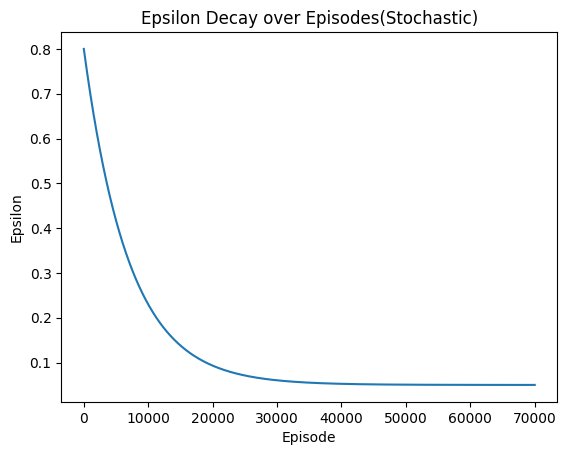

In [ ]:
plt.plot(epsilon_values)
plt.xlabel('Episode')
plt.ylabel('Epsilon')
plt.title('Epsilon Decay over Episodes(Stochastic)')
plt.show()

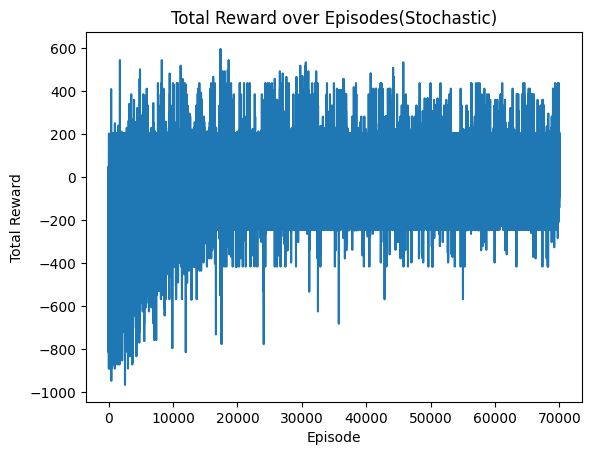

In [ ]:
plt.plot(total_rewards)
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Total Reward over Episodes(Stochastic)')
plt.show()

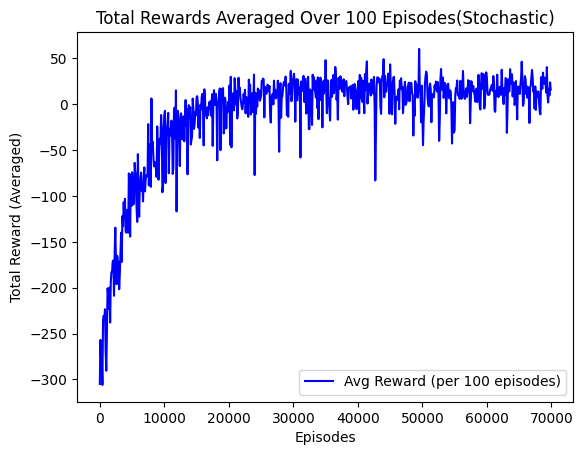

In [ ]:
smoothed_rewards = np.mean(np.array(total_rewards).reshape(-1, 100), axis=1)

# Plot the averaged rewards
plt.plot(range(0, len(total_rewards), 100), smoothed_rewards, label="Avg Reward (per 100 episodes)", color='blue')

# Labels and title
plt.xlabel("Episodes")
plt.ylabel("Total Reward (Averaged)")
plt.title("Total Rewards Averaged Over 100 Episodes(Stochastic)")
plt.legend()
plt.show()

In [ ]:
with open("Q_table_stochastic.pkl", "rb") as f:
    q_table = pickle.load(f)

env = EnvWareHouseSto()
episodes = 10

total_rewards = []

# Run 10 episodes using greedy policy
for episode in range(episodes):
    state, _ = env.reset()
    state_idx = np.argmax(state[0])  # Convert state to index for lookup
    done = False
    total_reward = 0

    while not done:
        action = np.argmax(q_table[state_idx])  # Always choose the best action (greedy)
        next_state, reward, done, _, _ = env.step(action)
        state_idx = np.argmax(next_state[0])  # Convert to index
        # print(state_idx)
        total_reward += reward

    total_rewards.append(total_reward)

# Plot total rewards per episode
plt.figure(figsize=(8, 5))
plt.plot(range(1, episodes + 1), total_rewards, marker='o', linestyle='-')
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("Total Reward per Episode (Greedy Policy)")
plt.grid()
plt.show()

KeyboardInterrupt: 

In [ ]:


# Load the trained Q-table
with open("Q_table_stochastic.pkl", "rb") as f:
    Q_table = pickle.load(f)

# Initialize environment
env = EnvWareHouseSto()

# Store frames for video
frames = []

# Run 1 greedy episode with rendering
state, _ = env.reset()
state_idx = np.argmax(state[0])  # Convert state to index
done = False
step = 0

while not done:
    action = np.argmax(Q_table[state_idx])  # Choose best action (greedy)
    next_state, reward, done, _, _ = env.step(action)

    # Render and save frame
    fig = plt.figure()
    # env.render()
    plt.savefig(f"frame_stochastic/step_{step}.png")  # Save each step as an image
    plt.close(fig)

    # Convert image to numpy array for video
    frame = imageio.imread(f"frame_stochastic/step_{step}.png")
    frames.append(frame)

    state_idx = np.argmax(next_state[0])  # Update state index
    step += 1

# Save the video
imageio.mimsave("warehouse_run.mp4", frames, fps=2)  # Save as MP4 video

print("Rendering complete. Screenshots saved in 'frames/' and video saved as 'warehouse_run.mp4'.")


<ipython-input-40-619add788579>:28: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  frame = imageio.imread(f"frame_stochastic/step_{step}.png")


KeyboardInterrupt: 

<Figure size 640x480 with 0 Axes>

Hyperparameter tuning

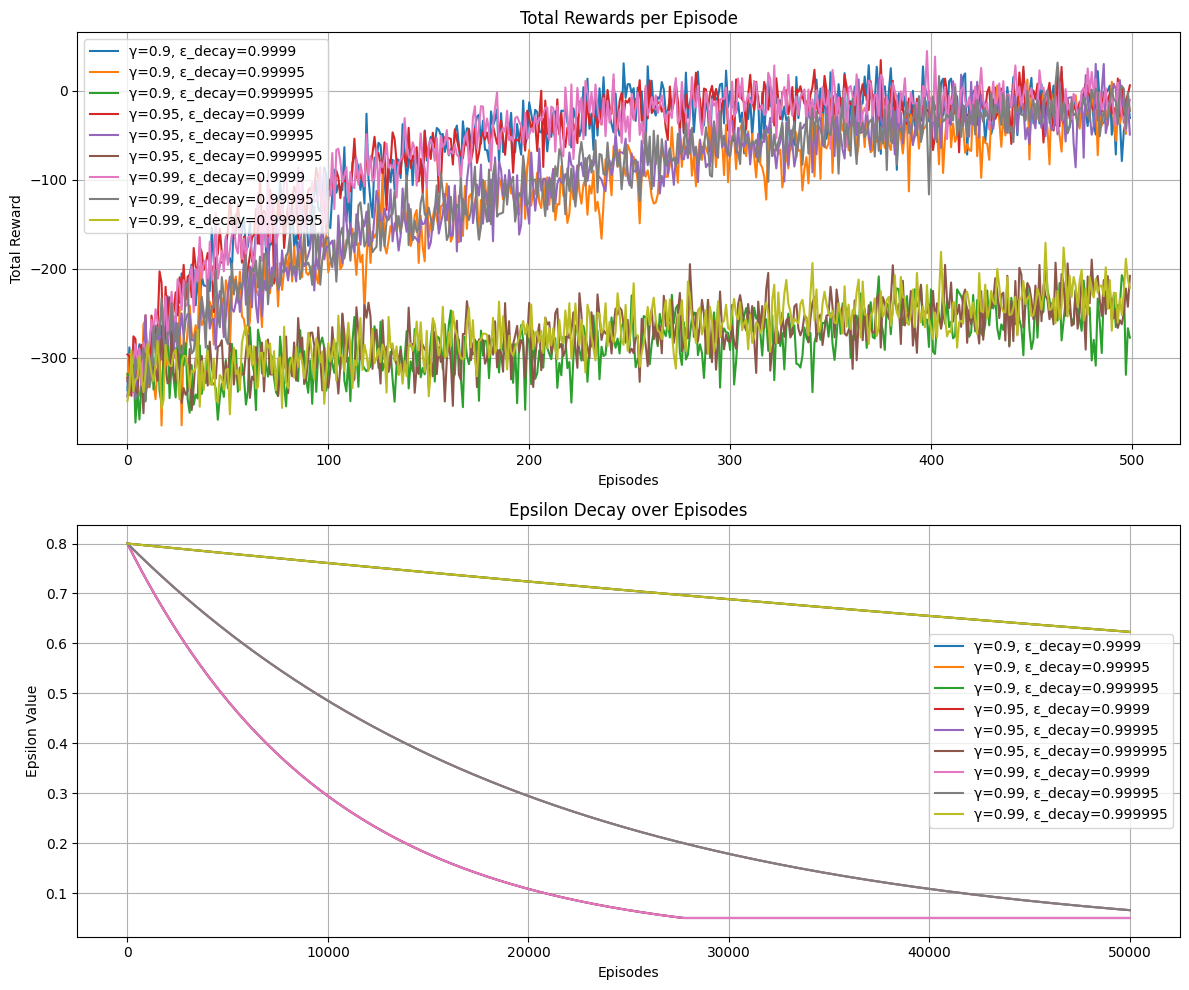

In [ ]:


# Define hyperparameter values to test
gamma_values = [0.9, 0.95, 0.99]  # Discount factor
epsilon_decay_values = [0.9999, 0.99995, 0.999995]  # Exploration decay rate

def train_q_learning(env, gamma, epsilon_decay, num_episodes=50000, alpha=0.7, epsilon=0.8, epsilon_min=0.05, max_steps=10):
    state_size = env.observation_space.n
    action_size = env.action_space.n
    q_table = np.zeros((state_size, action_size))
    total_rewards = []
    epsilon_values = []

    def state_index(state, env):
        grid_state, carry = state  # Unpack observation
        position = np.where(grid_state.reshape(env.grid, env.grid) == 1)
        pos_index = position[0][0] * env.grid + position[1][0]
        carry_bit = 1 if carry else 0
        return pos_index + carry_bit * (env.grid * env.grid)

    for episode in range(num_episodes):
        state = env.reset()
        total_reward = 0
        done = False

        for step in range(max_steps):
            state_id = state_index(state, env)
            action = np.argmax(q_table[state_id, :]) if np.random.rand() > epsilon else env.action_space.sample()
            next_state, reward, terminated, truncated, done = env.step(action)

            next_state_id = state_index(next_state, env)
            best_next_action = np.argmax(q_table[next_state_id, :])
            q_table[state_id, action] += alpha * (reward + gamma * q_table[next_state_id, best_next_action] - q_table[state_id, action])

            state = next_state
            total_reward += reward
            if done or terminated:
                break

        total_rewards.append(total_reward)
        epsilon = max(epsilon_min, epsilon * epsilon_decay)
        epsilon_values.append(epsilon)

    return total_rewards, epsilon_values, q_table

# Run experiments and plot results
fig, axes = plt.subplots(2, 1, figsize=(12, 10))
for gamma in gamma_values:
    for epsilon_decay in epsilon_decay_values:
        env = EnvWareHouseSto()
        total_rewards, epsilon_values, q_table = train_q_learning(env, gamma, epsilon_decay)
        smoothed_rewards = np.mean(np.array(total_rewards).reshape(-1, 100), axis=1)

        # Plot the averaged rewards
        axes[0].plot(smoothed_rewards, label=f'γ={gamma}, ε_decay={epsilon_decay}')

        # Plot epsilon decay over episodes
        axes[1].plot(epsilon_values, label=f'γ={gamma}, ε_decay={epsilon_decay}')

        # Save Q-table for best model
        with open(f'Q_table_gamma_{gamma}_epsilon_{epsilon_decay}.pkl', 'wb') as f:
            pickle.dump(q_table, f)

axes[0].set_title("Total Rewards per Episode")
axes[0].set_xlabel("Episodes")
axes[0].set_ylabel("Total Reward")
axes[0].legend()
axes[0].grid()

axes[1].set_title("Epsilon Decay over Episodes")
axes[1].set_xlabel("Episodes")
axes[1].set_ylabel("Epsilon Value")
axes[1].legend()
axes[1].grid()

plt.tight_layout()
plt.show()


SARSA for deterministic

In [ ]:
# Initialize parameters
alpha = 0.7            # Learning rate
gamma = 0.99           # Discount factor
epsilon = 0.8          # Initial exploration rate
epsilon_decay = 0.999995 # # Slower decay for extended exploration
epsilon_min = 0.05     # Minimum exploration rate
num_episodes = 70000   # More episodes for better training
max_steps = 10         # Max steps per episode


# Initialize Q-table
env = EnvWareHouseDet()  # Initialize warehouse environment
state_size = env.observation_space.n  # (Position index * Carrying status)
action_size = env.action_space.n
q_table = np.zeros((state_size, action_size))
returns = {}  # Stores total returns for state-action pairs
epsilon_value = []
total = []
# SARSA Training Loop
for episode in range(num_episodes):
    state = env.reset()
    action = choose_action(state, env)  # Select initial action
    total_reward = 0
    done = False

    for step in range(max_steps):
        state_id = state_index(state, env)

        # Take action and observe next state and reward
        next_state, reward, terminated, truncated, done = env.step(action)
        next_state_id = state_index(next_state, env)

        # Choose next action using ε-greedy
        next_action = choose_action(next_state, env)

        # SARSA update rule: Q(s, a) ← Q(s, a) + α [r + γ Q(s', a') - Q(s, a)]
        q_table[state_id, action] += alpha * (
            reward + gamma * q_table[next_state_id, next_action] - q_table[state_id, action]
        )

        state, action = next_state, next_action  # Move to next state-action pair
        total_reward += reward

        if done or terminated:
            break
    total.append(total_reward)
    # Decay epsilon
    epsilon = max(epsilon_min, epsilon * epsilon_decay)
    # epsilon = epsilon_min + (epsilon_max - epsilon_min) * np.exp(-decay_rate * episode)
    epsilon_value.append(epsilon)
    # Print progress every 500 episodes
    if (episode + 1) % 500 == 0:
        print(f"Episode {episode+1}/{num_episodes} | Total Reward: {total_reward:.2f} | Epsilon: {epsilon:.4f}")

# Save the Q-table
with open("Q_table_sarsa.pkl", "wb") as f:
    pickle.dump(q_table, f)

print("SARSA training complete!")

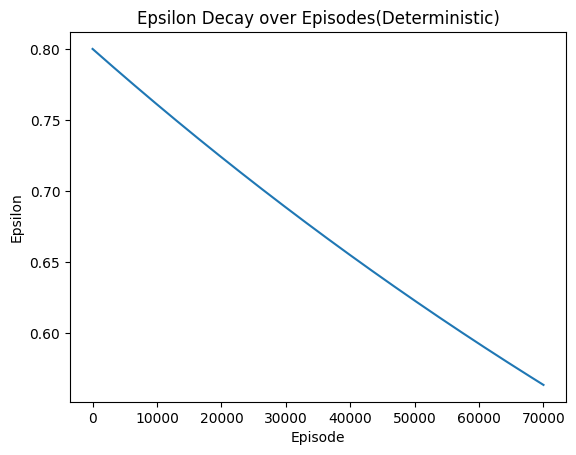

In [ ]:
plt.plot(epsilon_values)
plt.xlabel('Episode')
plt.ylabel('Epsilon')
plt.title('Epsilon Decay over Episodes(Deterministic)')
plt.show()